# Split Gene Family
Up to now, the gene family and version was hotencoded together. Let's see what happens if we split them and onehotencode the gene family and/or the whole gene family and version.



In [1]:
from util import get_train_dataset, get_test_dataset
train_df = get_train_dataset()
# train_df = train_df.sample(100)
y = train_df['reaction']
train_df.head()

,CDR3_alfa,TRAV,TRAJ,CDR3_beta,TRBV,TRBJ,reaction,TRAJ_family,TRAJ_version,TRAV_family,TRAV_version,TRBV_family,TRBV_version,TRBJ_family,TRBJ_version
0,NaN,NaN,NaN,CSARDGSGARSNQPQHF,TRBV20-1,TRBJ1-5,0,NaN,NaN,NaN,NaN,TRBV20,1.0,TRBJ1,5.0
1,NaN,NaN,NaN,CASSSGTGTSEQYF,TRBV5-1,TRBJ2-7,0,NaN,NaN,NaN,NaN,TRBV5,1.0,TRBJ2,7.0
2,CAFMKQRGGGADGLTF,TRAV38-1,TRAJ45,CASSISSGRGNEQFF,TRBV19,TRBJ2-1,0,TRAJ45,1.0,TRAV38,1,TRBV19,1.0,TRBJ2,1.0
3,CRNAGGTSYGKLTF,TRAV25,TRAJ52,CASSSHQRTGVDEQFF,TRBV27,TRBJ2-1,1,TRAJ52,1.0,TRAV25,1,TRBV27,1.0,TRBJ2,1.0
4,NaN,NaN,NaN,CASSPGPSGGLTYEQYF,TRBV5-4,TRBJ2-7,0,NaN,NaN,NaN,NaN,TRBV5,4.0,TRBJ2,7.0


As you can see, e.g. for TRAV, we have the whole gene family + version "TRAV38-1" (column TRAV) and the gene family "TRAV38" (column TRAV_family) and the version "1" (column TRAV_version). In the previous notebooks, we've only onehot encoded the TRAV column.

In [1]:
from sklearn import feature_extraction
import pandas as pd


ONEHOT_ENCODER = {"alfa": None, "beta": None}
ALPHA_OR_BETA = None # Should be set to "alfa" or "beta"

def onehot_encode(df, test=False, onehot_cols = None):
    global ONEHOT_ENCODER, ALPHA_OR_BETA
    assert ALPHA_OR_BETA in ["alfa", "beta"], f"ALPHA_OR_BETA must be set to 'alfa' or 'beta', is currently set to {ALPHA_OR_BETA}"

    # One hot encode the columns (creates a new column per unique value here and fills it with 1 or 0)
    onehot_cols = ['V', 'J'] if onehot_cols is None else onehot_cols
    if not test:
        ONEHOT_ENCODER[ALPHA_OR_BETA] = feature_extraction.DictVectorizer(sparse=False)
        encodings = ONEHOT_ENCODER[ALPHA_OR_BETA].fit_transform(df[onehot_cols].to_dict(orient='records'))
        # print(f"encoder {ALPHA_OR_BETA} fitted")
    else:
        assert ONEHOT_ENCODER[ALPHA_OR_BETA] is not None
        encodings = ONEHOT_ENCODER[ALPHA_OR_BETA].transform(df[onehot_cols].to_dict(orient='records'))
        # print(f"only transformed {ALPHA_OR_BETA}")

    # Get the columns of the onehot encoder
    columns = ONEHOT_ENCODER[ALPHA_OR_BETA].get_feature_names_out()
    # print(columns)

    onehot_df = pd.DataFrame(encodings, columns=ONEHOT_ENCODER[ALPHA_OR_BETA].get_feature_names_out())

    for col in columns:
        assert col in onehot_df.columns, f'Column {col} not in dataframe'

    return onehot_df

# this one is the same as famversion
def onehot_encode_test(df, onehot_columns=None):
    return onehot_encode(df, test=True, onehot_cols=onehot_columns)

def onehot_encode_fam(df, test=False):
    return onehot_encode(df, test=test, onehot_cols=['V_family', 'J_family'])

def onehot_encode_famversion(df, test=False):
    return onehot_encode(df, test=test, onehot_cols=['V', 'J'])

def onehot_encode_fam_and_famversion(df, test=False):
    return onehot_encode(df, test=test, onehot_cols=['V_family', 'J_family', 'V', 'J'])

def onehot_encode_fam_and_famversion_and_version(df, test=False):
    return onehot_encode(df, test=test, onehot_cols=['V_family', 'J_family', 'V', 'J', 'V_version', 'J_version'])


# The test functions (since the feature generator can only pass df as argument)
def onehot_encode_fam_test(df):
    return onehot_encode_fam(df, test=True)

def onehot_encode_famversion_test(df):
    return onehot_encode_famversion(df, test=True)

def onehot_encode_fam_and_famversion_test(df):
    return onehot_encode_fam_and_famversion(df, test=True)

def onehot_encode_fam_and_famversion_and_version_test(df):
    return onehot_encode_fam_and_famversion_and_version(df, test=True)

In [2]:
from util import cdr3_length, aa_occurances, physchem_properties, peptide_mass, pi_feature, pos_features


def get_baseline_feature_functions(test, onehot_encoder=None, onehot_encoder_test=None):
    onehot_encoder = onehot_encoder if onehot_encoder is not None else onehot_encode
    onehot_encoder_test = onehot_encoder_test if onehot_encoder_test is not None else onehot_encode_test
    if not test:
        feature_functions = [onehot_encoder, cdr3_length, aa_occurances, physchem_properties, peptide_mass, pi_feature,
                             pos_features]
    else:
        feature_functions = [onehot_encoder_test, cdr3_length, aa_occurances, physchem_properties, peptide_mass, pi_feature,
                             pos_features]
    return feature_functions


def get_baseline_sequence_features(df, test, onehot_encoder=None, onehot_encoder_test=None):
    features_list = []
    for feature_function in get_baseline_feature_functions(test, onehot_encoder, onehot_encoder_test):
        features = feature_function(df)
        assert features.shape[0] == df.shape[0], f'Feature function {feature_function} returned {features.shape[0]} rows, expected {df.shape[0]}'
        features_list.append(features.reset_index(drop=True))

    # Create one large dataframe, consisting of all the features (number of rows remains the same)
    features_in_one_df = pd.concat(features_list, axis=1)
    assert features_in_one_df.shape[0] == df.shape[0], f'Feature functions returned {features_in_one_df.shape[0]} rows, expected {df.shape[0]}'
    return features_in_one_df



def get_features(df, test=False, onehot_encoder=None, onehot_encoder_test=None):
    df_num_rows = df.shape[0]

    global ALPHA_OR_BETA

    chains = {"alfa": 'A', "beta": 'B'}
    all_chains_features = []
    for chain in chains:
        ALPHA_OR_BETA = chain

        short = chains[chain]
        rename_map = {f"CDR3_{chain}": "CDR3",
                      f"TR{short}V": "V",
                      f"TR{short}J": "J",
                      f"TR{short}V_family": "V_family",
                      f"TR{short}J_family": "J_family",
                      f"TR{short}V_version": "V_version",
                      f"TR{short}J_version": "J_version"}
        renamed = df[rename_map.keys()].rename(columns=rename_map)

        chain_features = get_baseline_sequence_features(renamed, test, onehot_encoder=onehot_encoder, onehot_encoder_test=onehot_encoder_test).add_prefix(f'{chain}_')

        all_chains_features.append(chain_features)

        chain_features_num_rows = chain_features.shape[0]

        assert df_num_rows == chain_features_num_rows, f"Number of rows in df ({df_num_rows}) and chain_features ({chain_features_num_rows}) must be the same"

    ALPHA_OR_BETA = None

    return pd.concat(all_chains_features, axis=1)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import impute
import numpy as np
from util import evaluate

onehot_encoders = {
    'fam': (onehot_encode_fam, onehot_encode_fam_test),
    'famversion': (onehot_encode_famversion, onehot_encode_famversion_test),
    'fam_and_famversion': (onehot_encode_fam_and_famversion, onehot_encode_fam_and_famversion_test),
    'fam_and_famversion_and_version': (onehot_encode_fam_and_famversion_and_version, onehot_encode_fam_and_famversion_and_version_test)
}
for ohe_name in onehot_encoders:
    print(f"Testing {ohe_name}...")

    ohe, ohe_test = onehot_encoders[ohe_name]

    train_features = get_features(train_df, onehot_encoder=ohe, onehot_encoder_test=ohe_test)

    clf = RandomForestClassifier(random_state=0)

    imputer_mean = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
    x_mean_imputed = imputer_mean.fit_transform(train_features)

    evaluate(clf, x_mean_imputed, y)

Testing fam...
[0.87598705 0.8840259  0.87380711 0.85696792 0.86815131]
ROC: 0.872 (+/- 0.018)
Testing famversion...
[0.87680682 0.88787855 0.87534254 0.85705139 0.87222209]
ROC: 0.874 (+/- 0.020)
Testing fam_and_famversion...
[0.88663244 0.89177755 0.88174885 0.86373839 0.87658437]
ROC: 0.880 (+/- 0.019)
Testing fam_and_famversion_and_version...
[0.8872125  0.89416635 0.88485305 0.87053063 0.8761087 ]
ROC: 0.883 (+/- 0.017)


Version seems to give a very small increase, so let's still try it with fam and famversion

In [3]:
def onehot_encode_fam_and_version(df, test=False):
    return onehot_encode(df, test=test, onehot_cols=['V_family', 'J_family', 'V_version', 'J_version'])

def onehot_encode_famversion_and_version(df, test=False):
    return onehot_encode(df, test=test, onehot_cols=['V', 'J', 'V_version', 'J_version'])

def onehot_encode_fam_and_version_test(df):
    return onehot_encode_fam_and_version(df, test=True)

def onehot_encode_famversion_and_version_test(df):
    return onehot_encode_famversion_and_version(df, test=True)

In [ ]:

onehot_encoders = {
    'fam_and_version': (onehot_encode_fam_and_version, onehot_encode_fam_and_version_test),
    'famversion_and_version': (onehot_encode_famversion_and_version, onehot_encode_famversion_and_version_test)
}
for ohe_name in onehot_encoders:
    print(f"Testing {ohe_name}...")

    ohe, ohe_test = onehot_encoders[ohe_name]

    train_features = get_features(train_df, onehot_encoder=ohe, onehot_encoder_test=ohe_test)

    clf = RandomForestClassifier(random_state=0)

    imputer_mean = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
    x_mean_imputed = imputer_mean.fit_transform(train_features)

    evaluate(clf, x_mean_imputed, y)

l88TOASK: Wanneer test dataset gebruiken?

## Results (test with NaNs)
| Onehot encoding                | AUC              | Notebook |
|--------------------------------|------------------|----------|
| fam                            | 0.872 (+/-0.018) | 15       |
| famversion                     | 0.874 (+/-0.020) | 15       |
| fam_and_famversion             | 0.880 (+/-0.019) | 15       |
| fam_and_famversion_and_version | 0.883 (+/-0.017) | 15       |
| fam_and_version                | 0.873 (+/-0.013) | 15       |
| famversion_and_version         | 0.875 (+/-0.021) | 15       |

Onehotencoding all three seems to give the best results (for the RF classifier we used). Also onehotencoding the version seems to give a small increase.

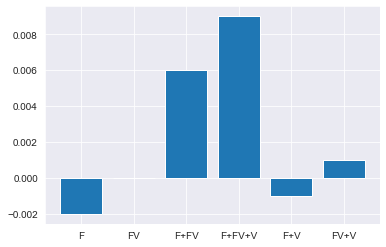

In [39]:
import matplotlib.pyplot as plt
scores = {"F": 0.872, "FV": 0.874, "F+FV": 0.880, "F+FV+V": 0.883, "F+V": 0.873, "FV+V": 0.875}
diff = [scores[score] - scores["FV"] for score in scores]
plt.bar(scores.keys(), diff)
plt.show()

In [7]:
from util import fix_test
from sklearn.model_selection import train_test_split

df = get_train_dataset()
# df = df.sample(1000)

train, test = train_test_split(df, test_size=0.2, random_state=42)

test.dropna(inplace=True)

In [31]:
from util import evaluate_no_cv
from sklearn.ensemble import HistGradientBoostingClassifier

onehot_encoders = {
    'fam': (onehot_encode_fam, onehot_encode_fam_test),
    'famversion': (onehot_encode_famversion, onehot_encode_famversion_test),
    'fam_and_famversion': (onehot_encode_fam_and_famversion, onehot_encode_fam_and_famversion_test),
    'fam_and_famversion_and_version': (onehot_encode_fam_and_famversion_and_version, onehot_encode_fam_and_famversion_and_version_test),
    'fam_and_version': (onehot_encode_fam_and_version, onehot_encode_fam_and_version_test),
    'famversion_and_version': (onehot_encode_famversion_and_version, onehot_encode_famversion_and_version_test)
}
for ohe_name in onehot_encoders:
    print(f"Testing {ohe_name}...")

    ohe, ohe_test = onehot_encoders[ohe_name]

    x = get_features(train, onehot_encoder=ohe, onehot_encoder_test=ohe_test)
    y = train['reaction']

    x_test = get_features(test, test=True, onehot_encoder=ohe, onehot_encoder_test=ohe_test)
    x_test = fix_test(x_test, x.columns)
    y_test = test['reaction']

    clf = HistGradientBoostingClassifier(random_state=0) # Warning: Using other classifier (and other test set) here, so don't compare results with previous output
    evaluate_no_cv(clf, x, y, x_test, y_test)

Testing fam...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


ROC AUC: 0.953
Testing famversion...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


ROC AUC: 0.968
Testing fam_and_famversion...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


ROC AUC: 0.969
Testing fam_and_famversion_and_version...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


ROC AUC: 0.967
Testing fam_and_version...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


ROC AUC: 0.956
Testing famversion_and_version...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


ROC AUC: 0.966


## Results (test without NaNs and with HistGradientBoostingClassifier)

| Onehot encoding                | AUC   | Notebook |
|--------------------------------|-------|----------|
| fam                            | 0.953 | 15       |
| famversion                     | 0.968 | 15       |
| fam_and_famversion             | 0.969 | 15       |
| fam_and_famversion_and_version | 0.967 | 15       |
| fam_and_version                | 0.956 | 15       |
| famversion_and_version         | 0.966 | 15       |



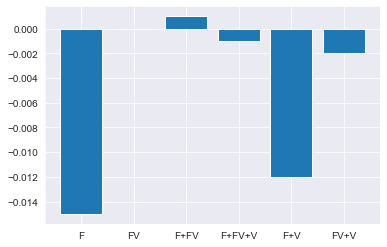

In [38]:
import matplotlib.pyplot as plt
scores = {"F": 0.953, "FV": 0.968, "F+FV": 0.969, "F+FV+V": 0.967, "F+V": 0.956, "FV+V": 0.966}
diff = [scores[score] - scores["FV"] for score in scores]
plt.bar(scores.keys(), diff)
plt.show()

The improvements are a lot smaller than our previous test. Let's try the test without NaN's again with a RF classifier to see whether the differences are because of the NaN's or because of the classifier.

In [12]:
from util import evaluate_no_cv
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn import impute
import numpy as np

onehot_encoders = {
    'fam': (onehot_encode_fam, onehot_encode_fam_test, "F"),
    'famversion': (onehot_encode_famversion, onehot_encode_famversion_test, "FV"),
    'fam_and_famversion': (onehot_encode_fam_and_famversion, onehot_encode_fam_and_famversion_test, "F+FV"),
    'fam_and_famversion_and_version': (onehot_encode_fam_and_famversion_and_version, onehot_encode_fam_and_famversion_and_version_test, "F+FV+V"),
    'fam_and_version': (onehot_encode_fam_and_version, onehot_encode_fam_and_version_test, "F+V"),
    'famversion_and_version': (onehot_encode_famversion_and_version, onehot_encode_famversion_and_version_test,"FV+V")
}
scores = dict()
for ohe_name in onehot_encoders:
    print(f"Testing {ohe_name}...")

    ohe, ohe_test, abbrev = onehot_encoders[ohe_name]

    x = get_features(train, onehot_encoder=ohe, onehot_encoder_test=ohe_test)
    y = train['reaction']

    x_test = get_features(test, test=True, onehot_encoder=ohe, onehot_encoder_test=ohe_test)
    x_test = fix_test(x_test, x.columns)
    y_test = test['reaction']


    clf = RandomForestClassifier(random_state=0)

    imputer_mean = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
    x_mean_imputed = imputer_mean.fit_transform(x)
    x_test_mean_imputed = imputer_mean.transform(x_test)

    score = evaluate_no_cv(clf, x_mean_imputed, y, x_test_mean_imputed, y_test)

    scores[abbrev] = score


Testing fam...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


ROC AUC: 0.937
Testing famversion...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


ROC AUC: 0.947
Testing fam_and_famversion...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


ROC AUC: 0.945
Testing fam_and_famversion_and_version...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


ROC AUC: 0.948
Testing fam_and_version...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


ROC AUC: 0.946
Testing famversion_and_version...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


ROC AUC: 0.949


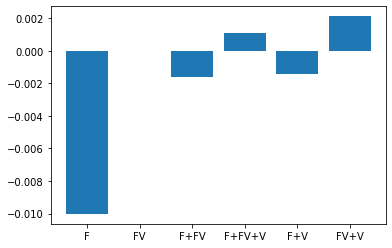

In [13]:
import matplotlib.pyplot as plt
diff = [scores[score] - scores["FV"] for score in scores]
plt.bar(scores.keys(), diff)
plt.show()

In [14]:
scores

{'F': 0.9370490767077521,
 'FV': 0.9470721025779945,
 'F+FV': 0.9454828660436138,
 'F+FV+V': 0.9481827622014538,
 'F+V': 0.9456634611043387,
 'FV+V': 0.9492031242945504}

In [ ]:
scores = {'F': 0.9370490767077521,
 'FV': 0.9470721025779945,
 'F+FV': 0.9454828660436138,
 'F+FV+V': 0.9481827622014538,
 'F+V': 0.9456634611043387,
 'FV+V': 0.9492031242945504}

| Onehot encoding                | AUC   | Notebook |
|--------------------------------|-------|----------|
| fam                            | 0.937 | 15       |
| famversion                     | 0.947 | 15       |
| fam_and_famversion             | 0.945 | 15       |
| fam_and_famversion_and_version | 0.948 | 15       |
| fam_and_version                | 0.946 | 15       |
| famversion_and_version         | 0.949 | 15       |

I think I still need to try cross validation here.

## Cross validation

In [12]:
from util import evaluate_no_cv, fix_test, get_train_dataset
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn import impute
import numpy as np
from sklearn.model_selection import train_test_split

onehot_encoders = {
    'fam': (onehot_encode_fam, onehot_encode_fam_test, "F"),
    'famversion': (onehot_encode_famversion, onehot_encode_famversion_test, "FV"),
    'fam_and_famversion': (onehot_encode_fam_and_famversion, onehot_encode_fam_and_famversion_test, "F+FV"),
    'fam_and_famversion_and_version': (onehot_encode_fam_and_famversion_and_version, onehot_encode_fam_and_famversion_and_version_test, "F+FV+V"),
    'fam_and_version': (onehot_encode_fam_and_version, onehot_encode_fam_and_version_test, "F+V"),
    'famversion_and_version': (onehot_encode_famversion_and_version, onehot_encode_famversion_and_version_test,"FV+V")
}

df = get_train_dataset()
# df = df.sample(200)

scores = pd.DataFrame()
for ohe_name in onehot_encoders:
    print(f"Testing {ohe_name}...")

    ohe, ohe_test, abbrev = onehot_encoders[ohe_name]

    for seed in range(5):
        train, test = train_test_split(df, test_size=0.2, random_state=seed)
        test.dropna(inplace=True)

        x = get_features(train, onehot_encoder=ohe, onehot_encoder_test=ohe_test)
        y = train['reaction']

        x_test = get_features(test, test=True, onehot_encoder=ohe, onehot_encoder_test=ohe_test)
        x_test = fix_test(x_test, x.columns)
        y_test = test['reaction']


        clf = HistGradientBoostingClassifier(random_state=0)

        imputer_mean = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
        x_mean_imputed = imputer_mean.fit_transform(x)
        x_test_mean_imputed = imputer_mean.transform(x_test)

        score = evaluate_no_cv(clf, x_mean_imputed, y, x_test_mean_imputed, y_test)

        scores = scores.append({"model": abbrev, "score": score}, ignore_index=True)

Testing fam...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.954


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.935


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.952


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.933


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.951
Testing famversion...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.964


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.949


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.959


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.956


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.961
Testing fam_and_famversion...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.961


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.952


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.958


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.955


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.963
Testing fam_and_famversion_and_version...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.962


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.949


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.961


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.958


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.960
Testing fam_and_version...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.945


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.936


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.948


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.938


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.952
Testing famversion_and_version...


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.964


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.952


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.961


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.956


C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


ROC AUC: 0.961


In [13]:
# Take the mean of the values in the dataframe where epitope is GILGFVFTL
baseline = scores[scores['model'] == 'FV']['score'].mean()
scores["improvement"] = scores["score"] - baseline
scores

,model,score,improvement
0,F,0.954381,-0.003563
1,F,0.935455,-0.022490
2,F,0.951748,-0.006197
3,F,0.933309,-0.024635
4,F,0.951272,-0.006673
5,FV,0.964072,0.006127
6,FV,0.948915,-0.009030
7,FV,0.959470,0.001526
8,FV,0.956298,-0.001647
9,FV,0.960969,0.003024


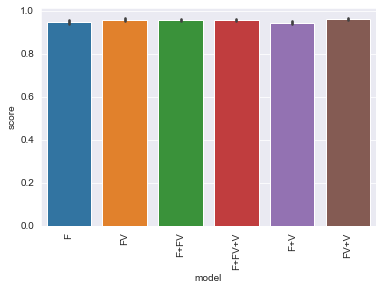

In [14]:
import seaborn as sns
plot = sns.barplot(x="model", y="score", data=scores, ci="sd")
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
pass

C:\Users\arnod\AppData\Local\Temp/ipykernel_37840/3001143889.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])


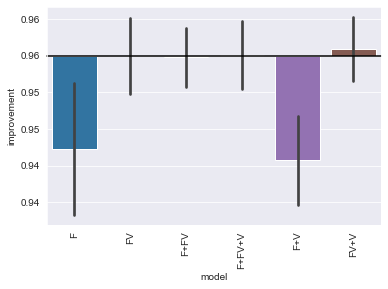

In [15]:
plot = sns.barplot(x="model", y="improvement", data=scores, ci="sd")

plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

plot.axhline(0, color="k", clip_on=False)
y_ticks = plot.get_yticks()
plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])
pass

This is quite interesting. It shows that FV is better for a random forest than F+V. This is probably because I'm using random forests, which aren't that good at linking information together.